In [1]:
import os
import pandas as pd
import numpy as np
import json
import re
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
results_df = pd.DataFrame()

Throughout this notebook, "old" data refers to the data used in the Severson et al. paper, while "new" data refers to the Battery Archive data. "Combined" or "old+new" data referes to when these two data sources are combined into one dataset.

There are quite a few conditionals in this notebook. Here is what the following booleans represent, as well as their recommended settings for the best elastic net model:

__ct__ [True]: Indicates whether charge throughput is the response variable (vs. cycle life)

__integrated_time_temp_cycles__ [optional]: Indicates whether X.integrated_time_temperature_cycles_1:100' should be a feature in the full model

__ir__ [False]: Indicates whether the internal resistance features should be present in the full model for the old data (internal resistance is not present in the new data)

__log_transformation__ [True]: Indicates whether a log transformation should be applied to the combined data

__scaled__ [True]: Indicates whether a Robust Scaler should be used to scale the data (scaling should always be used in an Elastic Net model)

__old_new_scaler__ [True]: Assuming the 'scaled' conditional is true, indicates that the old and new data should be scaled separately before it is combined (vs. combining first and then scaling)
    
__new_chemistries__ [True]: Indicates that the NCA and NMC battery chemistries should be included in the new data set

__chem_sources__ [True]: Assuming the 'new_chemistries' conditional is true, indicates whether the battery's chemistry (LFP, NCA, NMC) should be included as a feature in every model
    
__test_set__ [2 or 3 (half new or new unchanged)]: Assuming the 'new_chemistries' conditional is true, indicates which test set should be used. Set by stating the index of the desired test set, rather than True/False

    combination: Includes half of the old data and half of the new data in the test set
    new: Includes all of the new data in the test set
    half new: Includes half of the new data in the test set
    new unchanged: Includes the same batteries as were in the test set for the new data analyses
    LFP: Includes all of the LFP batteries in the new data in the test set
    NCA: Includes all of the NCA batteries in the new data in the test set
    NMC: Includes all of the NMC batteries in the new data in the test set
    old: Includes observations 84-139 of the old data set (these are the indexes not included in the initial old data analysis)
    
__sources__ [True]: Indicates whether the data's source (old data or battery archive data) should be included as a feature every model for the combined data

__environ__ [False]: Indicates whether the data's environment conditions are included. There are four variables:
    
    Temperature: Temperature the battery is tested at
    DOD: Depth of Discharge
    Discharge_rate: 
    Charge_rate: 
    

In [3]:
#True if using charge_throughput as response variable, False if using cycle life (X.capacity_0.8)
ct = True

#True if including 'X.integrated_time_temperature_cycles_1:100' to full model, False if not
integrated_time_temp_cycles = False

#True if including internal resistance for old data, False if not (no internal resistance variable for new data)
ir = False

#True if applying a log transformtion to combined data, False if no transformation
log_transformation = True

#True if scaling explanatory variables with Robust Scaler, False otherwise (necessary for elastic net)
scaled = True

if scaled:
    #True if using old and new data scaled separately in combined data, False if using a separate scaler for all combined data
    old_new_scaler = True

#True if using all battery chemistries, False if only LFP
new_chemistries = True

if new_chemistries:
    #True if tracking the sources of the new chemistries, False if not
    chem_sources = True
    
    #Identifies the combined data test set's chemistry, or identifies that there will be all new data or a combination all data
    #Old data will not be used if LFP is selected, but will be used if combination is selected
    test_set = ["combination", "new", "half new", "new unchanged", "LFP", "NCA", "NMC", "old"]
    test_set = test_set[3]
    
else:
    chem_sources = False
    
    test_set = ["combination", "new", "half new", "new unchanged", "LFP", "old", "half"]
    test_set = test_set[6]

#True if identifying the source of the data (old, new), False if not
sources = True

#True if using new environment variables
environ = True

In [4]:
cond = pd.Series({"ct": ct, "time_temp_cycle":integrated_time_temp_cycles, "log_y": log_transformation, "ir": ir, 
                  "standardized": scaled, "environ":environ, "sources_ind": sources, "other_chem": new_chemistries,
                  "separate_scaler": scaled})

When we reach a conditional, we create an if statement indicating whether the conditional is true. If the conditional is true, then we add whatever code necessary to meet the conditional, which is often only a few lines.

## Reading in the Data

You will need to change the path variable to fit where the data is stored. The data must be featurized through TRI's beep library in order to read in correctly. All necessary featurized data should already be present in the TRI-Capstone GitHub repo [https://github.com/ayakkala1/TRI-Capstone].

In [5]:
# David
path = "E:/Data/TRI/"

old_d_dir = path + "FastCharge/features/DeltaQFastCharge"
old_t_dir = path + "FastCharge/features/TrajectoryFastCharge"

#Folder
# path = "./"

# old_d_dir = path + "OldData/"
# old_t_dir = path + "TrajectoryFastCharge/"


def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if ".json" in fullPath:
            allFiles.append(fullPath)
    return allFiles

old_d_list = getListOfFiles(old_d_dir)
old_t_list = getListOfFiles(old_t_dir)

In [6]:
def get_new_names(d_list):
    new_names = []
    for file in d_list:
        new_names.append(re.findall("CH(.*?)\_f", file)[0])
    return new_names

def make_df(file_list, batch=False):
    df = pd.DataFrame()
    for file in file_list:
        with open(file) as data_file:    
            data = json.load(data_file)
            data_df = pd.json_normalize(data)
            df = pd.concat([df,data_df])
    df.reset_index(drop=True,inplace=True)
    if batch:
        df['bat_num'] = get_new_names(file_list)
    return df

def merge_df(d_df, t_df):
    df_full = d_df.merge(t_df, left_index=True, right_index=True)

    # Making values not stored as lists
    for column in df_full.columns:
        if "X." in column:
            df_full[column] = df_full[column].apply(lambda x: x[0])

    df_full.reset_index(inplace=True)
    return df_full

In [7]:
# For David - I have the full (FastCharge) data
old_d_df = make_df(old_d_list, batch=True)
old_d_df.head()

batches = []
for i in old_d_df['metadata.protocol']:
    if '2017-05' in i:
        batches.append('b1')
    elif '2017-06' in i:
        batches.append('b2')
    elif '2018-04' in i:
        batches.append('b3')

old_d_df['batches'] = batches
old_d_df['bat_name'] = old_d_df['batches'] + 'c' + old_d_df['bat_num']

In [8]:
# for matt - I don't have the full old data
# old_d_df = make_df(old_d_list, batch=True)
# old_d_df.head()

# batches = []
# for i in old_d_df['name']:
#     if "b1" in i:
#         batches.append('b1')
#     elif 'b2' in i:
#         batches.append('b2')
#     elif 'b3' in i:
#         batches.append('b3')

# old_d_df['batches'] = batches
# old_d_df['bat_name'] = old_d_df['batches'] + 'c' + old_d_df['bat_num']

In [9]:
old_t_df = make_df(old_t_list)
old_t_df.head()

,@module,@class,name,@version,X.capacity_0.98,X.capacity_0.95,X.capacity_0.92,X.capacity_0.89,X.capacity_0.86,X.capacity_0.83,X.capacity_0.8,metadata.barcode,metadata.protocol,metadata.channel_id,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap
0,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[127],[269],[376],[423],[449],[467],[483],el150800440551,2017-06-30_tests\20170630-4_4C_55per_6C.sdu,18,0.98,0.78,0.03
1,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[125],[276],[426],[528],[613],[668],[668],el150800737229,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,15,0.98,0.78,0.03
2,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[774],[774],[774],[774],[774],[774],[774],el150800737366,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,29,0.98,0.78,0.03
3,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[543],[543],[543],[543],[543],[543],[543],el150800737234,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,37,0.98,0.78,0.03
4,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[1011],[1011],[1011],[1011],[1011],[1011],[1011],el150800737329,2018-04-12_batch8\20180412-5C_67per_4C_newstru...,9,0.98,0.78,0.03


In [10]:
old_df_full = merge_df(old_d_df, old_t_df)
old_df_full.sort_values(by=['bat_name'],inplace=True)
old_df_full.head()

,index,@module_x,@class_x,name_x,@version_x,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference,X.discharge_capacity_cycle_100,X.integrated_time_temperature_cycles_1:100,X.charge_time_cycles_1:5,...,X.capacity_0.89,X.capacity_0.86,X.capacity_0.83,X.capacity_0.8,metadata.barcode_y,metadata.protocol_y,metadata.channel_id_y,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap
98,98,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.069159,0.609605,1.075878,194523.331238,768.000000,...,1191,1191,1191,1191,EL150800460514,2017-05-12_TESTS\20170512-3_6C-80PER_3_6C.SDU,0,0.98,0.78,0.03
13,13,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.021925,0.234529,1.010972,163310.066862,819.200012,...,528,663,665,665,EL150800460514,2017-05-12_TESTS\20170512-3_6C-80PER_3_6C.SDU,0,0.98,0.78,0.03
78,78,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.072973,0.607773,1.079325,182982.491752,563.200012,...,583,605,625,638,EL150800463886,2017-05-12_TESTS\20170512-4_8C-80PER_4_8C.SDU,9,0.98,0.78,0.03
96,96,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.070200,0.609325,1.061485,178767.125004,537.599976,...,441,492,525,536,EL150800464002,2017-05-12_TESTS\20170512-5_4C-80PER_5_4C.SDU,10,0.98,0.78,0.03
97,97,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.080072,0.606653,1.076906,184036.176107,512.000000,...,492,526,549,561,EL150800463871,2017-05-12_TESTS\20170512-5_4C-80PER_5_4C.SDU,11,0.98,0.78,0.03


In [11]:
old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")

In [12]:
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [13]:
if environ:
    old_ct["Temperature"] = 30
    old_ct["DOD"] = 100
    old_ct["Discharge_rate"] = 4
    old_ct["Charge_rate"] = 4.8

In [14]:
new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA.csv")

if new_chemistries:
    nca_df = pd.read_csv(path + "NewData/charge_throughputs_BA_NCA.csv")
    nmc_df = pd.read_csv(path + "NewData/charge_throughputs_BA_NMC.csv")
    
    chemistries = ["LFP", "NCA", "NMC"]
    dfs = [new_ct, nca_df, nmc_df]
    
    for i in range(len(chemistries)):
        chem = chemistries[i]
        for j in range(len(dfs)):
            df = dfs[j]
            
            if i == j:
                df[chem] = 1
            else:
                df[chem] = -1
            
            dfs[j] = df
        
    new_ct = pd.concat([df for df in dfs], ignore_index=True)

## Models

Setting the model variables for the old data

The variance, discharge, and full models were all introduced in the Severson et al. paper. See the paper for more information.

In [15]:
variance_model_features = ['X.abs_variance_discharge_capacity_difference_cycles_2:100']
discharge_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                            'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                            'X.abs_skew_discharge_capacity_difference_cycles_2:100',
                            'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                            'X.discharge_capacity_cycle_2',
                            'X.max_discharge_capacity_difference'
                            ]
full_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                       'X.slope_discharge_capacity_cycle_number_2:100',
                       'X.intercept_discharge_capacity_cycle_number_2:100',
                       'X.discharge_capacity_cycle_2',
                       'X.charge_time_cycles_1:5']

if integrated_time_temp_cycles:
    full_model_features.append('X.integrated_time_temperature_cycles_1:100')

if ir:
    full_model_features.append('X.min_internal_resistance_cycles_2:100')
    full_model_features.append('X.internal_resistance_difference_cycles_2:100')
    
if environ:
    variance_model_features.extend(('Temperature', 'DOD', 'Discharge_rate', 'Charge_rate'))
    discharge_model_features.extend(('Temperature', 'DOD', 'Discharge_rate', 'Charge_rate'))
    full_model_features.extend(('Temperature', 'DOD', 'Discharge_rate', 'Charge_rate'))

if ct:
    y = 'charge_throughput'
else:
    y = 'cycle_index'

In [16]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler

We fit the 3 model feature groups (variance, discharge, full), 3 data types (old, new, combined), and 2 model types (basic linear regression, elastic net) for 18 total model combinations. Throughout this notebook, we plot true vs. predicted values, RMSE comparisons, and MAPE comparisons to evaluate these models.

## Old Data

The following train-test split does not include all of the old data. This is because observations not included in this train-test split were collected at a separate time. This is the split used in the Severson et al. paper, and it is the one we will use when considering only the old data. Once we combine the old and new data, however, we will use all batteries from the old dataset, not just the 80 or so that are included now.

In [17]:
len(old_ct)

139

In [18]:
train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81]
test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]

We do not want to immediately apply the scaler to old_ct, since we want to still be able to see the true values if necessary. We will fit the scaler to the training set for each model, then apply it to the test set.

If 'old_new_scaler' is set to true, we create another file, X_all_old, that is the scaled version of all data in old_ct. This is the dataset we will combine with the scaled new data. The scaler for this data is also fit to the train set, then applied to all of the data.

In [19]:
all_model_features = full_model_features + list(set(discharge_model_features)-set(full_model_features))

if scaled:

    def scale(train, test):
        scaler = RobustScaler()
        scaler.fit(train)
        train_data = pd.DataFrame(scaler.transform(train), index=train.index, columns = train.columns)
        test_data = pd.DataFrame(scaler.transform(test), index=test.index, columns = test.columns)
        return [train_data, test_data]
    
    if old_new_scaler:
        X_train_all_old = old_ct.iloc[train_ind][all_model_features]
        temp_test_ind = list(set(old_ct.index)-set(train_ind))
        X_test_all_old = old_ct.iloc[temp_test_ind][all_model_features]

        X_train_all_old, X_test_all_old = scale(X_train_all_old, X_test_all_old)

        X_train_all_old[y] = old_ct.iloc[train_ind][y]
        X_test_all_old[y] = old_ct.iloc[temp_test_ind][y]

        X_all_old = X_train_all_old.append(X_test_all_old)
        
        X_test_all_old = X_test_all_old.iloc[test_ind]

### Variance Model [Old Data]

#### Linear Regression

In [20]:
X_train_var = old_ct.iloc[train_ind][variance_model_features]

y_train = old_ct.iloc[train_ind][[y]]

X_test_var = old_ct.iloc[test_ind][variance_model_features]
y_test = old_ct.iloc[test_ind][[y]]

if scaled:
    X_train_var, X_test_var = scale(X_train_var, X_test_var)

In [21]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

In [22]:
rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)*100
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)*100

print("Variance Basic Linear Regression Model")
# print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
# print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Test RMSE:  214.30059910503815
Mean % Test Error:  14.850105828362189


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (LR) [Old Data]')

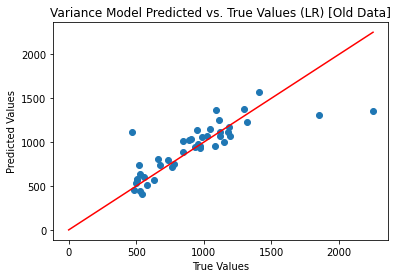

In [23]:
# Variance model
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (LR) [Old Data]")

#### Elastic Net

In [24]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_var, y_train.values.ravel())

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_var.fit(X_train_var, y_train.values.ravel())
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
    mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)*100
    mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)*100

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)
    train_mapes.append(mape_train_en_var)
    test_mapes.append(mape_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

In [25]:
elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]
mape_train_var_en = train_mapes[best_model_index]
mape_test_var_en = test_mapes[best_model_index]

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)
print("Test Mean Absolute % Error: ", mape_test_var_en)

Variance Elastic Net Model
l1_ratio = 1.0
Test RMSE:  214.31490921731057
Test Mean Absolute % Error:  14.84608304212864


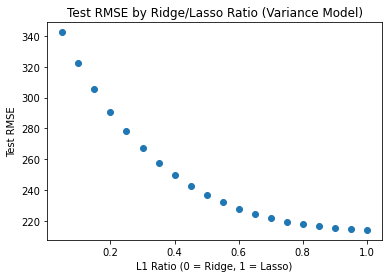

In [26]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (EN) [Old Data]')

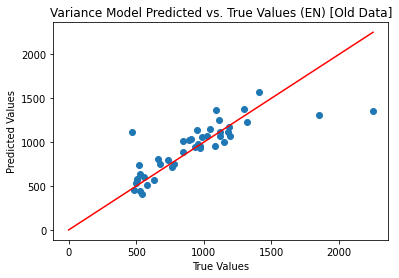

In [27]:
#Elastic Net
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (EN) [Old Data]")

In [28]:
model_name = "Variance"
source = "Old"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_var, "EN_rmse":rmse_test_var_en, 
                                                      "L_mape": mape_test_var, "EN_mape":mape_test_var_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_var.coef_})),
                               ignore_index=True)

#### From paper (Variance Model)
* Training RMSE: 103
* Test RMSE: 138
* Mean % Train Error: 14.1
* Mean % Test Error: 14.7

### Discharge Model [Old Data]

#### Linear Regression

In [29]:
X_train_dis = old_ct.iloc[train_ind][discharge_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_dis = old_ct.iloc[test_ind][discharge_model_features]
y_test = old_ct.iloc[test_ind][[y]]

if scaled:
    X_train_dis, X_test_dis = scale(X_train_dis, X_test_dis)

In [30]:
reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

In [31]:
rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)*100
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)*100

print("Discharge Basic Linear Regression Model")
# print("Training RMSE: ", rmse_train_dis)
print("Test RMSE: ", rmse_test_dis)
# print("Train Mean % Error: ", mape_train_dis)
print("Test Mean % Error: ", mape_test_dis)

Discharge Basic Linear Regression Model
Test RMSE:  335.3509910185474
Test Mean % Error:  19.830829496603794


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (LR) [Old Data]')

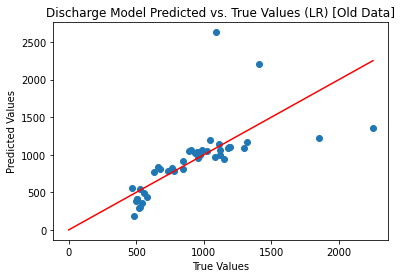

In [32]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (LR) [Old Data]")

#### Elastic Net

In [33]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_dis, y_train.values.ravel())

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train.values.ravel())
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
    mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)*100
    mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)*100

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)
    train_mapes.append(mape_train_en_dis)
    test_mapes.append(mape_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

In [34]:
elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]
mape_train_dis_en = train_mapes[best_model_index]
mape_test_dis_en = test_mapes[best_model_index]

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)
print("Test Mean Absolute % Error: ", mape_test_dis_en)

Discharge Elastic Net Model
l1_ratio = 1.0
Test RMSE:  320.4875724191322
Test Mean Absolute % Error:  17.042335780495055


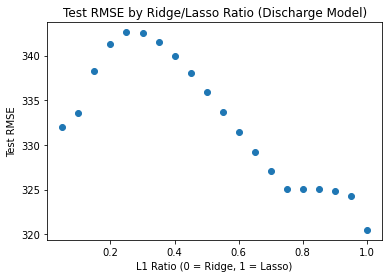

In [35]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (EN) [Old Data]')

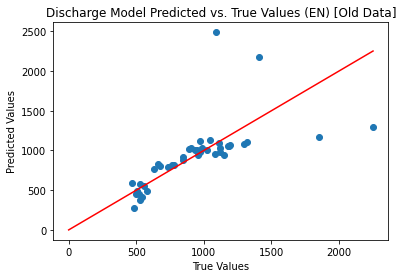

In [36]:
#Elastic Net
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (EN) [Old Data]")

#### From paper (Discharge Model)
* Training RMSE: 76
* Test RMSE: 91
* Mean % Train Error: 9.8
* Mean % Test Error: 13.0

In [37]:
model_name = "Discharge"
source = "Old"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_dis, "EN_rmse":rmse_test_dis_en, 
                                                      "L_mape": mape_test_dis, "EN_mape":mape_test_dis_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_dis.coef_})),
                               ignore_index=True)

### Full Model [Old Data]

#### Linear Regression

In [38]:
X_train_full = old_ct.iloc[train_ind][full_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_full = old_ct.iloc[test_ind][full_model_features]
y_test = old_ct.iloc[test_ind][[y]]

if scaled:
    X_train_full, X_test_full = scale(X_train_full, X_test_full)

In [39]:
reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

In [40]:
rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)*100
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)*100

print("Full Basic Linear Regression Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Test RMSE:  216.1417833155752
Mean % Test Error:  0.16906215860652746


Text(0.5, 1.0, 'Full Model Predicted vs. True Values (LR) [Old Data]')

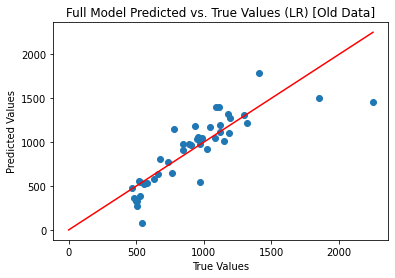

In [41]:
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (LR) [Old Data]")

#### Elastic Net

In [42]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_full, y_train.values.ravel())

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_full.fit(X_train_full, y_train.values.ravel())
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
    mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)*100
    mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)*100

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)
    train_mapes.append(mape_train_en_full)
    test_mapes.append(mape_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

In [43]:
elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]
mape_train_full_en = train_mapes[best_model_index]
mape_test_full_en = test_mapes[best_model_index]

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)
print("Test Mean Absolute % Error: ", mape_test_full_en)

Full Elastic Net Model
l1_ratio = 0.9
Test RMSE:  202.1301770707469
Test Mean Absolute % Error:  14.13177537391475


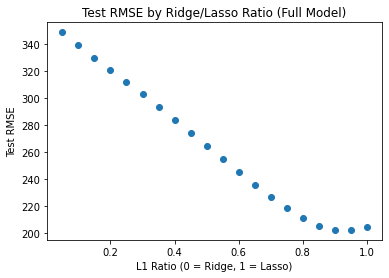

In [44]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Full Model Predicted vs. True Values (EN) [Old Data]')

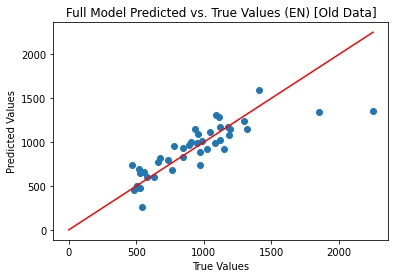

In [45]:
#Elastic Net
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (EN) [Old Data]")

In [46]:
model_name = "Full"
source = "Old"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_full, "EN_rmse":rmse_test_full_en, 
                                                      "L_mape": mape_test_full, "EN_mape":mape_test_full_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_full.coef_})),
                               ignore_index=True)

#### From paper (Full Model)
* Training RMSE: 51
* Test RMSE: 118
* Mean % Train Error: 5.6
* Mean % Test Error: 14.1

### Old Data Plots

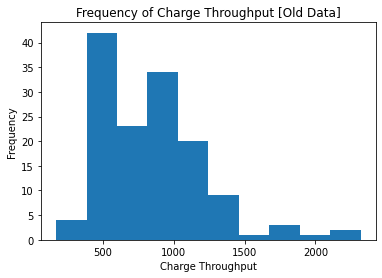

In [47]:
plt.hist(old_ct[y])
plt.ylabel('Frequency')
if ct:
    plt.xlabel('Charge Throughput')
    plt.title('Frequency of Charge Throughput [Old Data]')
else:
    plt.xlabel('Cycle Life')
    plt.title('Frequency of Cycle Life [Old Data]')

In [48]:
old_data_metrics = pd.DataFrame(data = {
    
                               "Model & Source": ["Var (Linear)", "Var (E.N.)", "Var (Paper)",
                                                  "Disc (Linear)", "Disc (E.N.)", "Disc (Paper)",
                                                  "Full (Linear)", "Full (E.N.)", "Full (Paper)"],
                               
                               "Model": ["Variance", "Variance", "Variance",
                                         "Discharge", "Discharge", "Discharge",
                                         "Full", "Full", "Full"],
                                        
                               "Source": ["Us (Basic Linear)", "Us (Elastic Net)", "Paper (Elastic Net)",
                                          "Us (Basic Linear)", "Us (Elastic Net)", "Paper (Elastic Net)",
                                          "Us (Basic Linear)", "Us (Elastic Net)", "Paper (Elastic Net)"],
                                        
                               "Train RMSE": [rmse_train_var, rmse_train_var_en, 103,
                                              rmse_train_dis, rmse_train_dis_en, 76,
                                              rmse_train_full, rmse_train_full_en, 51],
                               
                               "Test RMSE": [rmse_test_var, rmse_test_var_en, 138,
                                             rmse_test_dis, rmse_test_dis_en, 91, 
                                             rmse_test_full, rmse_test_full_en, 118],
                               
                               "Train MAPE": [mape_train_var, mape_train_var_en, 14.1,
                                              mape_train_dis, mape_train_dis_en, 9.8,
                                              mape_train_full, mape_train_full_en, 5.6],
                               
                               "Test MAPE": [mape_test_var, mape_test_var_en, 14.7,
                                             mape_test_dis, mape_test_dis_en, 13.0,
                                             mape_test_full, mape_test_full_en, 14.1]})

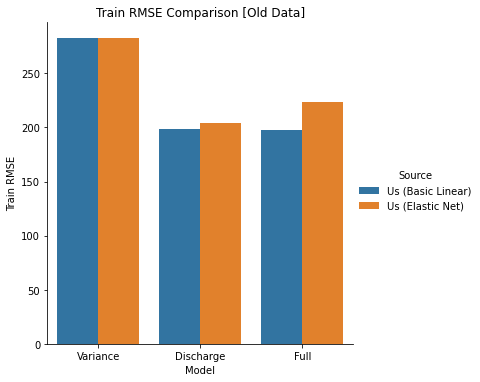

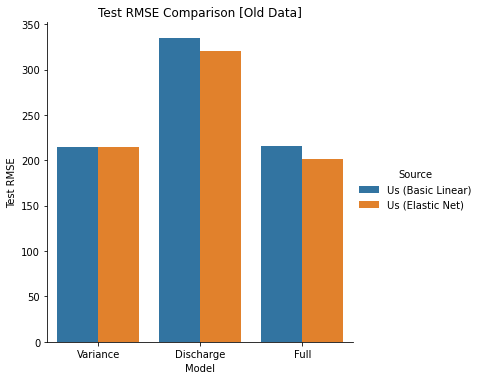

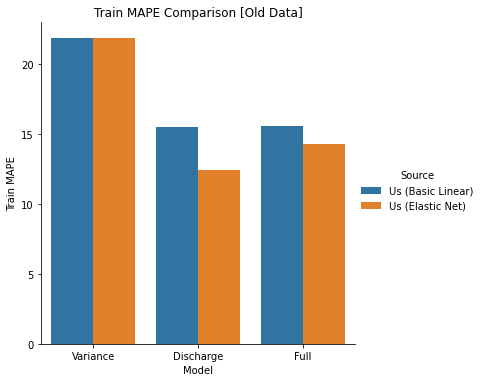

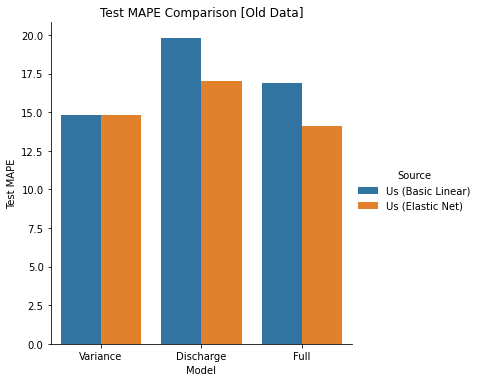

In [49]:
if ct:
    old_data_metrics = old_data_metrics.iloc[[0,1,3,4,6,7]]
for column in old_data_metrics.columns[3:]:
    sns.catplot(data = old_data_metrics, kind="bar",
               x = "Model", y = column, hue = "Source")
    plt.title(column + " Comparison [Old Data]")

In [50]:
#Removing internal_resistance features for models with new data
if ir:
    full_model_features.remove('X.min_internal_resistance_cycles_2:100')
    full_model_features.remove('X.internal_resistance_difference_cycles_2:100')
    
    if scaled:
        all_model_features.remove('X.min_internal_resistance_cycles_2:100')
        all_model_features.remove('X.internal_resistance_difference_cycles_2:100')

## New Data

### Reading in the data

In [51]:
new_df = pd.read_csv(path + "NewData/LFPBatteries.csv")

if new_chemistries:
    nca = pd.read_csv(path + "NewData/NCABatteries.csv")
    nmc = pd.read_csv(path + "NewData/NMCBatteries.csv")
    
    new_df = pd.concat([new_df, nca, nmc], ignore_index=True)
    
    chemistries = ["X.LFP", "X.NCA", "X.NMC"]
    
    if chem_sources:
        variance_model_features = variance_model_features + chemistries
        discharge_model_features = discharge_model_features + chemistries
        full_model_features = full_model_features + chemistries

In [52]:
new_ct_full = new_df.merge(how = 'inner',right = new_ct, left_index = True, right_index=True)
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

if environ:
    new_ct_full["Temperature"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[1][:2]))
    new_ct_full["DOD"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[2].split("-")[1]))
    new_ct_full["Charge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[0]))
    new_ct_full["Discharge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[1][:-1]))

In [53]:
new_ct_full

,X.abs_first_discharge_capacity_difference_cycles_2:100,X.abs_kurtosis_discharge_capacity_difference_cycles_2:100,X.abs_mean_discharge_capacity_difference_cycles_2:100,X.abs_min_discharge_capacity_difference_cycles_2:100,X.abs_skew_discharge_capacity_difference_cycles_2:100,X.abs_variance_discharge_capacity_difference_cycles_2:100,X.charge_time_cycles_1:5,X.discharge_capacity_cycle_100,X.discharge_capacity_cycle_2,X.integrated_time_temperature_cycles_1:100,...,X.battery,charge_throughput,X.cycle_index,X.LFP,X.NCA,X.NMC,Temperature,DOD,Charge_rate,Discharge_rate
0,-3.309824,1.867028,-2.742859,-0.446806,0.584775,-3.166992,5760.000000,1.032,1.030,306697.588291,...,LFP_15C_0-100_0.5-1C_a_CH00,4524.021,4550.0,1,-1,-1,15,100,0.5,1.0
1,-3.019408,2.349816,-2.648706,-0.208776,0.993881,-3.056759,5785.600098,1.042,1.040,296427.402899,...,LFP_15C_0-100_0.5-1C_a_CH01,3577.625,3552.0,1,-1,-1,15,100,0.5,1.0
2,-2.312774,1.694375,-1.917594,-0.195631,0.655882,-2.478396,5811.200195,1.030,1.030,262556.750559,...,LFP_15C_0-100_0.5-1C_a_CH02,3680.164,3760.0,1,-1,-1,15,100,0.5,1.0
3,-2.677882,1.495850,-2.076420,-0.631730,0.057256,-2.981589,5785.600098,1.025,1.029,268508.727464,...,LFP_15C_0-100_0.5-1C_a_CH03,3655.051,3753.0,1,-1,-1,15,100,0.5,1.0
4,-2.005443,0.393445,-1.682799,-0.189399,-0.220132,-1.291194,5785.600098,1.059,1.067,614925.496456,...,LFP_15C_0-100_0.5-1C_a_CH04,3058.955,3049.0,1,-1,-1,15,100,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,-0.701052,0.395033,-1.747525,0.351140,-0.299305,-0.327336,2150.399902,2.617,2.945,688295.406421,...,NMC_25C_40-60_0.5-3C_b_CH25_struct,6965.715,11148.0,-1,-1,1,25,60,0.5,3.0
79,-0.766416,0.488745,-1.573092,0.371751,-2.863442,-0.333385,2150.399902,2.642,2.967,695101.448533,...,NMC_35C_0-100_0.5-1C_a_CH26_struct,1627.971,785.0,-1,-1,1,35,100,0.5,1.0
80,-0.894346,0.547362,-1.822007,0.342701,-0.171990,-0.438810,2124.800049,2.645,2.899,691622.108800,...,NMC_35C_0-100_0.5-1C_b_CH27_struct,1956.561,785.0,-1,-1,1,35,100,0.5,1.0
81,-0.653234,0.191814,-2.706233,0.161041,-0.187615,-0.512972,2150.399902,2.653,2.957,634530.826457,...,NMC_35C_0-100_0.5-1C_c_CH28_struct,1638.455,784.0,-1,-1,1,35,100,0.5,1.0


In [54]:
train_ind = [i for i in range(0, len(new_ct_full), 2)]
test_ind = [i for i in range(1, len(new_ct_full), 2)]

new_test_ind = test_ind

In [55]:
if scaled:
    if old_new_scaler:
        if new_chemistries & chem_sources:
            all_model_features = all_model_features + chemistries
        X_train_all_new = new_ct_full.iloc[train_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_train_all_new.dropna(axis=0, inplace=True)
        X_test_all_new = new_ct_full.iloc[test_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_test_all_new.dropna(axis=0, inplace=True)

        X_train_all_new, X_test_all_new = scale(X_train_all_new, X_test_all_new)

        X_train_all_new[y] = new_ct_full.iloc[train_ind][y]
        X_test_all_new[y] = new_ct_full.iloc[test_ind][y]
        
        X_all_new = X_train_all_new.append(X_test_all_new)

### Variance Model [New Data]

#### Linear Regression

In [56]:
X_train_var = new_ct_full.iloc[train_ind][variance_model_features]
X_train_var.dropna(axis=0, inplace=True)
y_train = new_ct_full.iloc[X_train_var.index][[y]]

X_test_var = new_ct_full.iloc[test_ind][variance_model_features]
X_test_var.dropna(axis=0, inplace=True)
y_test = new_ct_full.iloc[X_test_var.index][[y]]

if scaled:
    X_train_var, X_test_var = scale(X_train_var, X_test_var)

In [57]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

In [58]:
rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)*100
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)*100

print("Variance Basic Linear Regression Model")
# print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
# print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Test RMSE:  1175.0380725070397
Mean % Test Error:  35.86005527931024


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (LR) [New Data]')

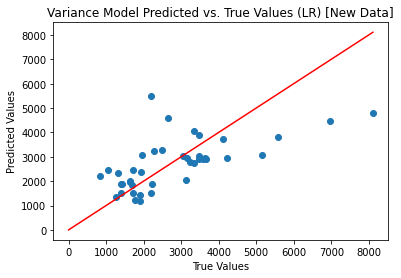

In [59]:
# Linear Regression
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (LR) [New Data]")

#### Elastic Net

In [60]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_var, y_train.values.ravel())

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_var.fit(X_train_var, y_train.values.ravel())
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
    mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)*100
    mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)*100

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)
    train_mapes.append(mape_train_en_var)
    test_mapes.append(mape_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

In [61]:
elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]
mape_train_var_en = train_mapes[best_model_index]
mape_test_var_en = test_mapes[best_model_index]

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)
print("Test Mean Absolute % Error: ", mape_test_var_en)

Variance Elastic Net Model
l1_ratio = 1.0
Test RMSE:  1430.5009397581957
Test Mean Absolute % Error:  48.602164227757235


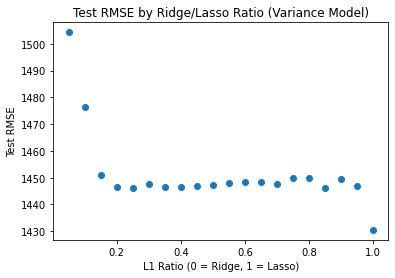

In [62]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (EN) [New Data]')

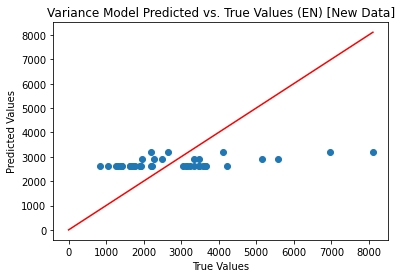

In [63]:
#Elastic Net
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (EN) [New Data]")

In [64]:
model_name = "Variance"
source = "New"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_var, "EN_rmse":rmse_test_var_en, 
                                                      "L_mape": mape_test_var, "EN_mape":mape_test_var_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_var.coef_})),
                               ignore_index=True)

### Discharge Model [New Data]

#### Linear Regression

In [65]:
X_train_dis = new_ct_full.iloc[train_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_train_dis.dropna(axis=0, inplace=True)
y_train = new_ct_full.iloc[X_train_dis.index][[y]]

X_test_dis = new_ct_full.iloc[test_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_test_dis.dropna(axis=0, inplace=True)
y_test = new_ct_full.iloc[X_test_dis.index][[y]]

if scaled:
    X_train_dis, X_test_dis = scale(X_train_dis, X_test_dis)

In [66]:
reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

In [67]:
rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)*100
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)*100

print("Discharge Basic Linear Regression Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_dis))

Discharge Basic Linear Regression Model
Test RMSE:  924.6478860348253
Mean % Test Error:  0.29745366879274004


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (LR) [New Data]')

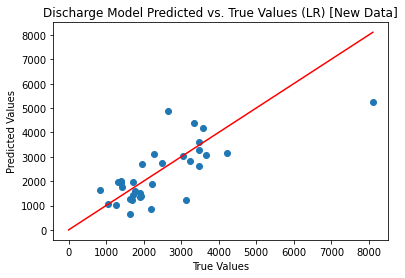

In [68]:
# Linear Regression
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (LR) [New Data]")

#### Elastic Net

In [69]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_dis, y_train.values.ravel())

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train.values.ravel())
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
    mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)*100
    mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)*100

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)
    train_mapes.append(mape_train_en_dis)
    test_mapes.append(mape_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

In [70]:
elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]
mape_train_dis_en = train_mapes[best_model_index]
mape_test_dis_en = test_mapes[best_model_index]

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)
print("Test Mean Absolute % Error: ", mape_test_dis_en)

Discharge Elastic Net Model
l1_ratio = 0.35
Test RMSE:  1137.4466513364969
Test Mean Absolute % Error:  40.56062318904791


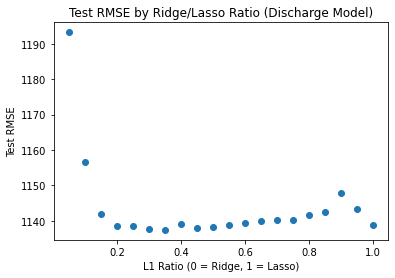

In [71]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (EN) [New Data]')

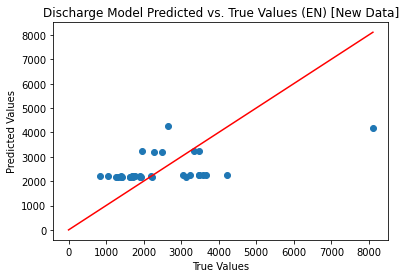

In [72]:
#Elastic Net
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (EN) [New Data]")

In [73]:
model_name = "Discharge"
source = "New"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_dis, "EN_rmse":rmse_test_dis_en, 
                                                      "L_mape": mape_test_dis, "EN_mape":mape_test_dis_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_dis.coef_})),
                               ignore_index=True)

### Full Model [New Data]

#### Linear Regression

In [74]:
X_train_full = new_ct_full.iloc[train_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_train_full.dropna(axis=0, inplace=True) 
y_train = new_ct_full.iloc[X_train_full.index][[y]]

X_test_full = new_ct_full.iloc[test_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_test_full.dropna(axis=0, inplace=True) 
y_test = new_ct_full.iloc[X_test_full.index][[y]]

if scaled:
    X_train_full, X_test_full = scale(X_train_full, X_test_full)

In [75]:
reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

In [76]:
rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)*100
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)*100

print("Full Basic Linear Regression Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Test RMSE:  930.1035107548528
Mean % Test Error:  0.27750433294039933


Text(0.5, 1.0, 'Full Model Predicted vs. True Values (LR) [New Data]')

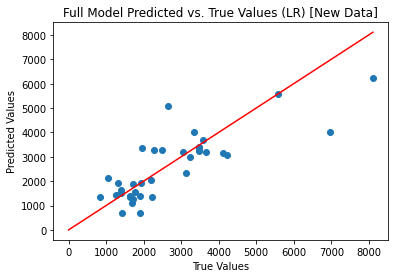

In [77]:
#Linear Regression
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (LR) [New Data]")

#### Elastic Net

In [78]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    
    elasticnetcv.fit(X_train_full, y_train.values.ravel())

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )
    
    elasticnet_full.fit(X_train_full, y_train.values.ravel())
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
    mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)*100
    mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)*100

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)
    train_mapes.append(mape_train_en_full)
    test_mapes.append(mape_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

In [79]:
elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]
mape_train_full_en = train_mapes[best_model_index]
mape_test_full_en = test_mapes[best_model_index]

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)
print("Test Mean Absolute % Error: ", mape_test_full_en)

Full Elastic Net Model
l1_ratio = 0.95
Test RMSE:  1302.6628623860872
Test Mean Absolute % Error:  36.52856988275888


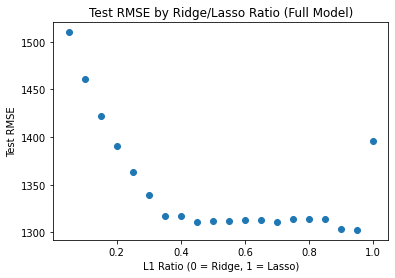

In [80]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Full Model Predicted vs. True Values (EN) [New Data]')

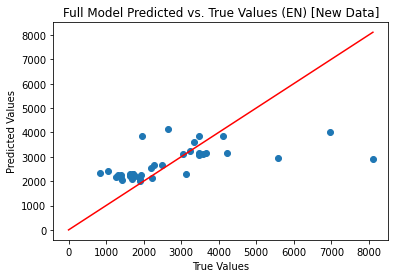

In [81]:
#Elastic Net
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (EN) [New Data]")

In [82]:
model_name = "Full"
source = "New"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_full, "EN_rmse":rmse_test_full_en, 
                                                      "L_mape": mape_test_full, "EN_mape":mape_test_full_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_full.coef_})),
                               ignore_index=True)

### New Data Plots

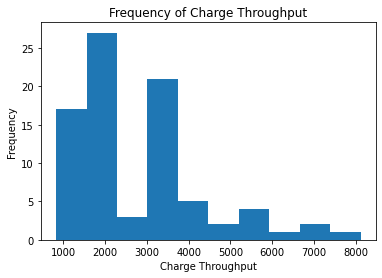

In [83]:
plt.hist(new_ct_full[y])
plt.ylabel('Frequency')
if ct:
    plt.xlabel('Charge Throughput')
    plt.title('Frequency of Charge Throughput')
else:
    plt.xlabel('Cycle Life')
    plt.title('Frequency of Cycle Life (New Data)')

In [84]:
new_data_metrics = pd.DataFrame(data = {
    
                               "Model & Source": ["Var (Linear)", "Var (E.N.)", 
                                                  "Disc (Linear)", "Disc (E.N.)",
                                                  "Full (Linear)", "Full (E.N.)"],
                               
                               "Model": ["Variance", "Variance",
                                         "Discharge", "Discharge",
                                         "Full", "Full"],
                                        
                               "Source": ["Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net"],
                                        
                               "Train RMSE": [rmse_train_var, rmse_train_var_en,
                                              rmse_train_dis, rmse_train_dis_en,
                                              rmse_train_full, rmse_train_full_en],
                               
                               "Test RMSE": [rmse_test_var, rmse_test_var_en,
                                             rmse_test_dis, rmse_test_dis_en,
                                             rmse_test_full, rmse_test_full_en],
                               
                               "Train MAPE": [mape_train_var, mape_train_var_en,
                                              mape_train_dis, mape_train_dis_en,
                                              mape_train_full, mape_train_full_en],
                               
                               "Test MAPE": [mape_test_var, mape_test_var_en,
                                             mape_test_dis, mape_test_dis_en,
                                             mape_test_full, mape_test_full_en]})

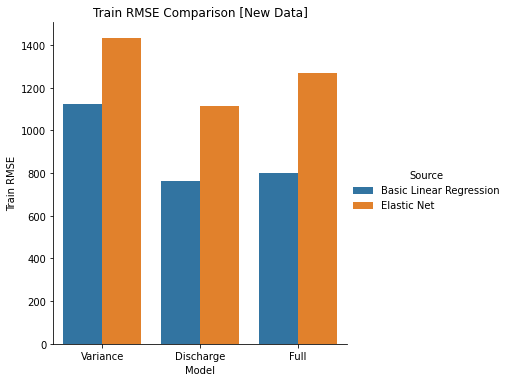

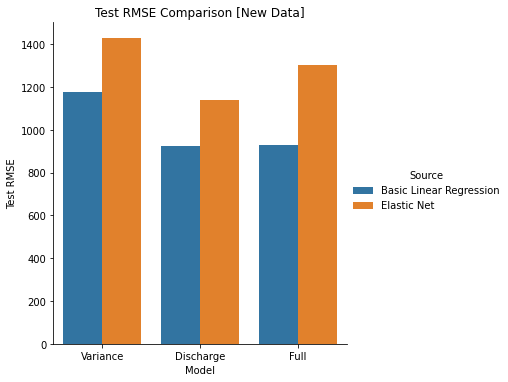

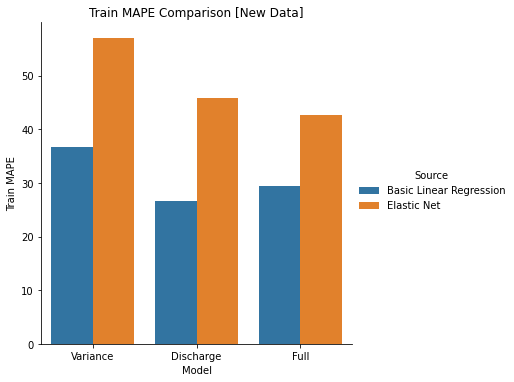

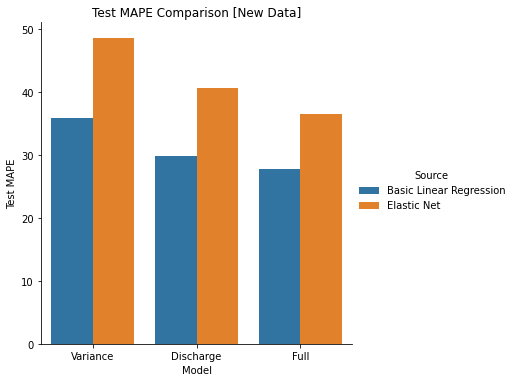

In [85]:
for column in new_data_metrics.columns[3:]:
    sns.catplot(data = new_data_metrics, kind="bar",
               x = "Model", y = column, hue = "Source")
    plt.title(column + " Comparison [New Data]")

## Combined (Old+New) Data

### Combining the old and new data

In [86]:
if sources:
    old_ct["Source"] = -1
    new_ct_full["Source"] = 1
    variance_model_features.append("Source")
    discharge_model_features.append("Source")
    full_model_features.append("Source")

if new_chemistries & chem_sources:
    old_ct["X.LFP"] = new_ct_full.iloc[0]["X.LFP"]
    old_ct["X.NCA"] = new_ct_full.iloc[0]["X.NCA"]
    old_ct["X.NMC"] = new_ct_full.iloc[0]["X.NMC"]

In [87]:
full_data = old_ct.append(new_ct_full)
full_data = full_data.reset_index()

In [88]:
if scaled:
    if old_new_scaler:
        if sources:
            X_all_old["Source"] = -1
            X_all_new["Source"] = 1
            all_model_features.append("Source")
            
        if new_chemistries & chem_sources:
            X_all_old["X.LFP"] = 1
            X_all_old["X.NCA"] = -1
            X_all_old["X.NMC"] = -1

            for chem in chemistries:
                X_all_new[chem].replace(0, -1, inplace=True)
            
        full_data = X_all_old.append(X_all_new)
        full_data = full_data.reset_index()

In [89]:
X_all_new

,X.abs_min_discharge_capacity_difference_cycles_2:100,X.abs_variance_discharge_capacity_difference_cycles_2:100,X.slope_discharge_capacity_cycle_number_2:100,X.intercept_discharge_capacity_cycle_number_2:100,X.discharge_capacity_cycle_2,X.charge_time_cycles_1:5,Temperature,DOD,Discharge_rate,Charge_rate,X.abs_kurtosis_discharge_capacity_difference_cycles_2:100,X.max_discharge_capacity_difference,X.abs_skew_discharge_capacity_difference_cycles_2:100,X.LFP,X.NCA,X.NMC,charge_throughput,Source
0,-0.671244,-1.032908,1.147150,-0.924180,-0.929348,0.966216,-1.0,0.0,0.0,0.0,1.462216,-0.882938,1.080344,1.0,-1.0,-1.0,4524.021,1
2,-0.329434,-0.686155,1.146856,-0.925186,-0.929348,0.979730,-1.0,0.0,0.0,0.0,1.263151,-0.886251,1.188896,1.0,-1.0,-1.0,3680.164,1
4,-0.320952,-0.088323,1.100553,-0.904178,-0.911067,0.972973,-1.0,0.0,0.0,0.0,-0.236789,-0.861403,-0.148437,1.0,-1.0,-1.0,3058.955,1
6,-0.255616,-0.590864,1.140131,-0.921433,-0.926877,0.972973,-1.0,0.0,0.0,0.0,1.298193,-0.881281,1.428713,1.0,-1.0,-1.0,3530.338,1
8,-0.778695,-0.683816,1.137143,-0.915101,-0.919960,0.972973,-1.0,0.0,0.0,0.0,0.131079,-0.875759,0.000000,1.0,-1.0,-1.0,3058.092,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.353815,0.428084,-0.216197,0.073492,0.026680,-0.013514,0.0,0.0,2.0,0.0,-0.633154,0.138045,-0.458303,-1.0,-1.0,1.0,1393.135,1
69,0.354040,0.438714,-0.240450,0.077634,0.030632,0.000000,0.0,0.0,2.0,0.0,-0.673930,0.143567,-0.827211,-1.0,-1.0,1.0,2235.783,1
77,0.431034,0.411659,-0.144427,0.072703,0.025692,0.020270,0.0,-40.0,2.0,0.0,-0.294569,0.122584,-0.422702,-1.0,-1.0,1.0,8109.346,1
79,0.442684,0.393996,-0.165913,0.073857,0.027668,0.013514,1.0,0.0,0.0,0.0,-0.126910,0.128106,-4.183742,-1.0,-1.0,1.0,1627.971,1


In [90]:
if test_set == "combination":
    test_ind = [i for i in range(0, len(full_data), 2)]

elif test_set == "new":
    test_ind = [j for j in range(len(old_ct),len(full_data))]

elif test_set == "half new":
    test_ind = [j for j in range(len(old_ct),len(full_data),2)]

elif test_set == "new unchanged":
    test_ind = list(full_data.iloc[139:][full_data["index"].isin(new_test_ind)].index)

elif test_set == "LFP":
    test_ind = list(full_data.iloc[len(old_ct):][(full_data["X.LFP"] > 0)].index)

elif test_set == "old":
    test_ind = list(full_data.iloc[84:len(old_ct)].index)

if new_chemistries:
    
    if test_set == "NCA":
        test_ind = list(full_data[full_data["X.NCA"] > 0].index)
        
    elif test_set == "NMC":
        test_ind = list(full_data[full_data["X.NMC"] > 0].index)
        
train_ind = list(set(full_data.index) - set(test_ind))

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


### Variance Model [Combined Data]

#### Linear Regression

In [91]:
X_train_var = full_data.iloc[train_ind][variance_model_features]
X_train_var.dropna(axis=0, inplace=True)
y_train = full_data.iloc[X_train_var.index][[y]]

X_test_var = full_data.iloc[test_ind][variance_model_features]
X_test_var.dropna(axis=0, inplace=True)
y_test = full_data.iloc[X_test_var.index][[y]]

if scaled:
    if not old_new_scaler:
        X_train_var, X_test_var = scale(X_train_var, X_test_var)

# log transformation
if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [92]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

if log_transformation:
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    y_pred_train_var = np.exp(y_pred_train_var)
    y_pred_test_var = np.exp(y_pred_test_var)

In [93]:
rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)*100
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)*100

print("Variance Basic Linear Regression Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Training RMSE:  651.7135776826642
Test RMSE:  2237.229674713518
Mean % Train Error:  18.999101368465272
Mean % Test Error:  44.429471759218416


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (LR) [Combined Data]')

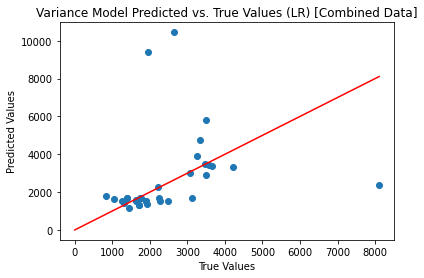

In [94]:
# Variance model
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (LR) [Combined Data]")

#### Elastic Net

In [95]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    
    if log_transformation:
        y_train = np.log(y_train)
        y_test = np.log(y_test)
        
    elasticnetcv.fit(X_train_var, y_train.values.ravel())

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )
    
    elasticnet_var.fit(X_train_var, y_train.values.ravel())
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    if log_transformation:
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
        y_pred_train_en_var = np.exp(y_pred_train_en_var)
        y_pred_test_en_var = np.exp(y_pred_test_en_var)
    
    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
    mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)*100
    mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)*100

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)
    train_mapes.append(mape_train_en_var)
    test_mapes.append(mape_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

In [96]:
elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]
mape_train_var_en = train_mapes[best_model_index]
mape_test_var_en = test_mapes[best_model_index]

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)
print("Test Mean Absolute % Error: ", mape_test_var_en)

Variance Elastic Net Model
l1_ratio = 0.05
Test RMSE:  1854.3565180868143
Test Mean Absolute % Error:  40.38946924887328


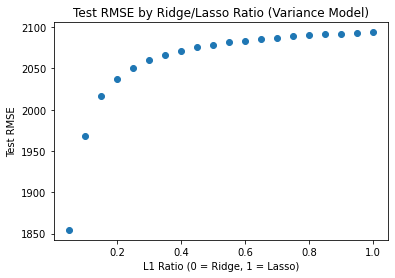

In [97]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (EN) [Combined Data]')

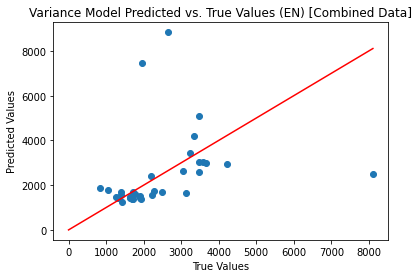

In [98]:
#Elastic Net
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (EN) [Combined Data]")

In [99]:
model_name = "Variance"
source = "Old+New"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_var, "EN_rmse":rmse_test_var_en, 
                                                      "L_mape": mape_test_var, "EN_mape":mape_test_var_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_var.coef_,
                                                      "test_set": test_set})),
                               ignore_index=True)

### Discharge Model [Combined Data]

#### Linear Regression

In [100]:
if environ:
    discharge_model_features.remove("Temperature")
    discharge_model_features.remove("DOD")
    discharge_model_features.remove("Discharge_rate")
    discharge_model_features.remove("Charge_rate")
X_train_dis = full_data.iloc[train_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_test_dis = full_data.iloc[test_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan)

if environ:
    discharge_model_features.extend(("Temperature", "DOD", "Discharge_rate", "Charge_rate"))
    X_train_dis = full_data.iloc[X_train_dis.index][discharge_model_features]
    X_test_dis = full_data.iloc[X_test_dis.index][discharge_model_features]
    
X_train_dis.dropna(axis=0, inplace=True)
y_train = full_data.iloc[X_train_dis.index][[y]]

X_test_dis.dropna(axis=0, inplace=True)
y_test = full_data.iloc[X_test_dis.index][[y]]

if scaled:
    if not old_new_scaler:
        X_train_dis, X_test_dis = scale(X_train_dis, X_test_dis)
    
if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [101]:
reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

if log_transformation:
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    y_pred_train_dis = np.exp(y_pred_train_dis)
    y_pred_test_dis = np.exp(y_pred_test_dis)

In [102]:
rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)*100
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)*100

print("Discharge Basic Linear Regression Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_dis))

Discharge Basic Linear Regression Model
Test RMSE:  1998.4062064033988
Mean % Test Error:  0.4015099971084342


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (LR) [Combined Data]')

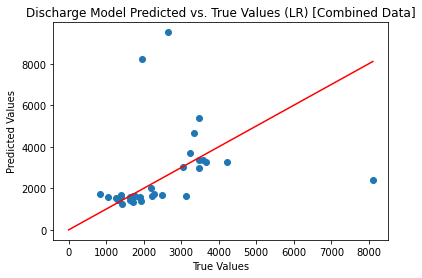

In [103]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (LR) [Combined Data]")

#### Elastic Net

In [104]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    
    if log_transformation:
        y_train = np.log(y_train)
        y_test = np.log(y_test)
    
    elasticnetcv.fit(X_train_dis, y_train.values.ravel())

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train.values.ravel())
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    if log_transformation:
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
        y_pred_train_en_dis = np.exp(y_pred_train_en_dis)
        y_pred_test_en_dis = np.exp(y_pred_test_en_dis)

    
    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
    mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)*100
    mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)*100

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)
    train_mapes.append(mape_train_en_dis)
    test_mapes.append(mape_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

In [105]:
elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]
mape_train_dis_en = train_mapes[best_model_index]
mape_test_dis_en = test_mapes[best_model_index]

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)
print("Test Mean Absolute % Error: ", mape_test_dis_en)

Discharge Elastic Net Model
l1_ratio = 0.05
Test RMSE:  1802.2401840889472
Test Mean Absolute % Error:  39.09483534059756


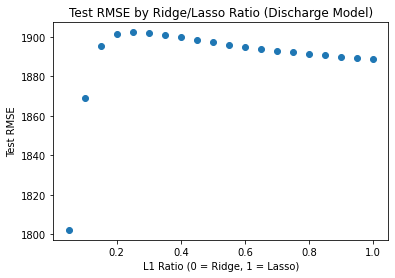

In [106]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (EN) [Combined Data]')

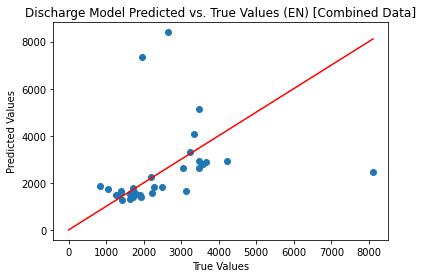

In [107]:
#Elastic Net
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (EN) [Combined Data]")

In [108]:
model_name = "Discharge"
source = "Old+New"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_dis, "EN_rmse":rmse_test_dis_en, 
                                                      "L_mape": mape_test_dis, "EN_mape":mape_test_dis_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_dis.coef_,
                                                      "test_set": test_set})),
                               ignore_index=True)

### Full Model [Combined Data]

#### Linear Regression

In [109]:
if environ:
    full_model_features.remove("Temperature")
    full_model_features.remove("DOD")
    full_model_features.remove("Discharge_rate")
    full_model_features.remove("Charge_rate")
X_train_full = full_data.iloc[train_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_test_full = full_data.iloc[test_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan)

if environ:
    full_model_features.extend(("Temperature", "DOD", "Discharge_rate", "Charge_rate"))
    X_train_full = full_data.iloc[X_train_full.index][full_model_features]
    X_test_full = full_data.iloc[X_test_full.index][full_model_features]
    
X_train_full.dropna(axis=0, inplace=True)
y_train = full_data.iloc[X_train_full.index][[y]]


X_test_full.dropna(axis=0, inplace=True)
y_test = full_data.iloc[X_test_full.index][[y]]

if scaled:
    if not old_new_scaler:
        X_train_full, X_test_full = scale(X_train_full, X_test_full)

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [110]:
reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

if log_transformation:
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    y_pred_train_full = np.exp(y_pred_train_full)
    y_pred_test_full = np.exp(y_pred_test_full)

In [111]:
rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)*100
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)*100

print("Full Basic Linear Regression Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Test RMSE:  2139.2782199291705
Mean % Test Error:  0.4176029420253656


Text(0.5, 1.0, 'Full Model Predicted vs. True Values (LR) [Combined Data]')

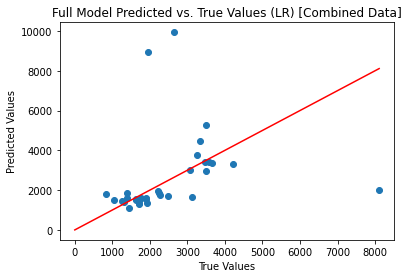

In [112]:
# Linear Regression
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (LR) [Combined Data]")

#### Elastic Net

In [113]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    
    if log_transformation:
        y_train = np.log(y_train)
        y_test = np.log(y_test)
        
    elasticnetcv.fit(X_train_full, y_train.values.ravel())

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_full.fit(X_train_full, y_train.values.ravel())
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    if log_transformation:
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
        y_pred_train_en_full = np.exp(y_pred_train_en_full)
        y_pred_test_en_full = np.exp(y_pred_test_en_full)
        
    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
    mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)*100
    mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)*100

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)
    train_mapes.append(mape_train_en_full)
    test_mapes.append(mape_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

In [114]:
elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]
mape_train_full_en = train_mapes[best_model_index]
mape_test_full_en = test_mapes[best_model_index]

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)
print("Test Mean Absolute % Error: ", mape_test_full_en)

Full Elastic Net Model
l1_ratio = 0.05
Test RMSE:  1947.4785734091274
Test Mean Absolute % Error:  41.979254612076716


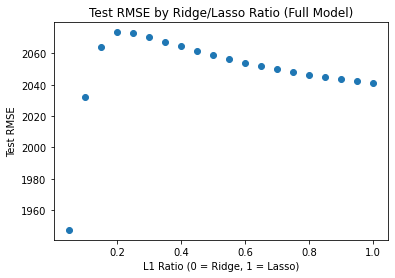

In [115]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Full Model Predicted vs. True Values (EN) [Combined Data]')

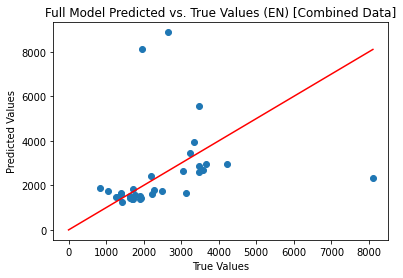

In [116]:
#Elastic Net
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (EN) [Combined Data]")

In [117]:
model_name = "Full"
source = "Old+New"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_full, "EN_rmse":rmse_test_full_en, 
                                                      "L_mape": mape_test_full, "EN_mape":mape_test_full_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_full.coef_,
                                                      "test_set": test_set})),
                               ignore_index=True)

In [118]:
results_df

,EN_mape,EN_rmse,L_mape,L_rmse,coef,ct,data,environ,ir,log_y,model,other_chem,separate_scaler,sources_ind,standardized,time_temp_cycle,test_set
0,14.846083,214.314909,14.850106,214.300599,"[-470.46743401388335, 0.0, 0.0, 0.0, 0.0]",1.0,Old,1.0,0.0,1.0,Variance,1.0,1.0,1.0,1.0,0.0,NaN
1,17.042336,320.487572,19.830829,335.350991,"[-98.68914706029618, -125.29539557842855, 30.2...",1.0,Old,1.0,0.0,1.0,Discharge,1.0,1.0,1.0,1.0,0.0,NaN
2,14.131775,202.130177,16.906216,216.141783,"[-268.9116750499399, -190.43748661936712, -22....",1.0,Old,1.0,0.0,1.0,Full,1.0,1.0,1.0,1.0,0.0,NaN
3,48.602164,1430.500940,35.860055,1175.038073,"[-0.0, -0.0, -293.0439969471471, -0.0, 0.0, 0....",1.0,New,1.0,0.0,1.0,Variance,1.0,1.0,1.0,1.0,0.0,NaN
4,40.560623,1137.446651,29.745367,924.647886,"[-4.88096244246171, -5.911987686128606, 6.1923...",1.0,New,1.0,0.0,1.0,Discharge,1.0,1.0,1.0,1.0,0.0,NaN
5,36.528570,1302.662862,27.750433,930.103511,"[-134.65153702725306, -89.70665555640777, 149....",1.0,New,1.0,0.0,1.0,Full,1.0,1.0,1.0,1.0,0.0,NaN
6,40.389469,1854.356518,44.429472,2237.229675,"[-0.45946447202400736, -0.0340924107877987, -0...",1.0,Old+New,1.0,0.0,1.0,Variance,1.0,1.0,1.0,1.0,0.0,new unchanged
7,39.094835,1802.240184,40.151000,1998.406206,"[-0.1291058716686948, -0.21387402221230223, 0....",1.0,Old+New,1.0,0.0,1.0,Discharge,1.0,1.0,1.0,1.0,0.0,new unchanged
8,41.979255,1947.478573,41.760294,2139.278220,"[-0.1789653521890864, -0.2244336080552326, 0.0...",1.0,Old+New,1.0,0.0,1.0,Full,1.0,1.0,1.0,1.0,0.0,new unchanged


## Old + New Data Plots

C:\Users\david\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


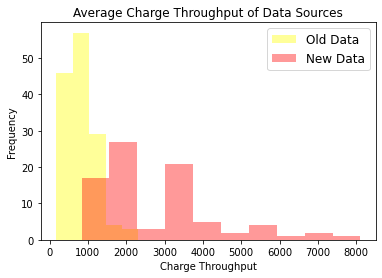

In [119]:
sns.distplot(old_ct[y], kde=False, color="yellow", label='Old Data', bins=5)
sns.distplot(new_ct_full[y], kde=False, color="red", label='New Data', bins=10)

# Plot formatting
plt.legend(prop={'size': 12})
if ct:
    plt.title('Average Charge Throughput of Data Sources')
    plt.xlabel('Charge Throughput')
else:
    plt.title('Average Cycle Life of Data Sources')
    plt.xlabel('Cycle Life')
plt.ylabel('Frequency');

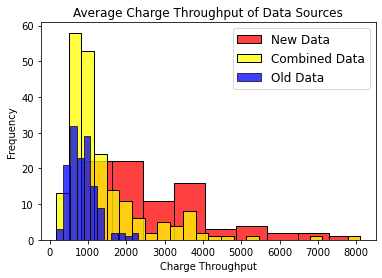

In [120]:
sns.histplot(new_ct_full[y], color="red", label='New Data')
sns.histplot(full_data[y], color = "yellow", label = 'Combined Data')
sns.histplot(old_ct[y], color="blue", label='Old Data')

# Plot formatting
plt.legend(prop={'size': 12})
if ct:
    plt.title('Average Charge Throughput of Data Sources')
    plt.xlabel('Charge Throughput')
else:
    plt.title('Average Cycle Life of Data Sources')
    plt.xlabel('Cycle Life')
plt.ylabel('Frequency');

In [121]:
all_data_metrics = pd.DataFrame(data = {
    
                               "Model & Source": ["Var (Linear)", "Var (E.N.)", 
                                                  "Disc (Linear)", "Disc (E.N.)",
                                                  "Full (Linear)", "Full (E.N.)"],
                               
                               "Model": ["Variance", "Variance",
                                         "Discharge", "Discharge",
                                         "Full", "Full"],
                                        
                               "Source": ["Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net"],
                                        
                               "Train RMSE": [rmse_train_var, rmse_train_var_en,
                                              rmse_train_dis, rmse_train_dis_en,
                                              rmse_train_full, rmse_train_full_en],
                               
                               "Test RMSE": [rmse_test_var, rmse_test_var_en,
                                             rmse_test_dis, rmse_test_dis_en,
                                             rmse_test_full, rmse_test_full_en],
                               
                               "Train MAPE": [mape_train_var, mape_train_var_en,
                                              mape_train_dis, mape_train_dis_en,
                                              mape_train_full, mape_train_full_en],
                               
                               "Test MAPE": [mape_test_var, mape_test_var_en,
                                             mape_test_dis, mape_test_dis_en,
                                             mape_test_full, mape_test_full_en]
})

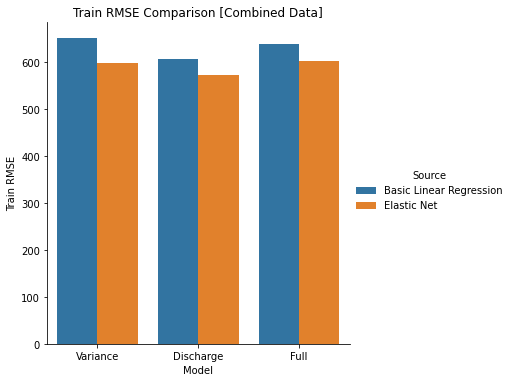

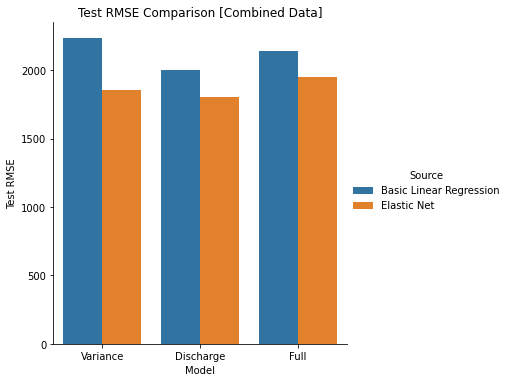

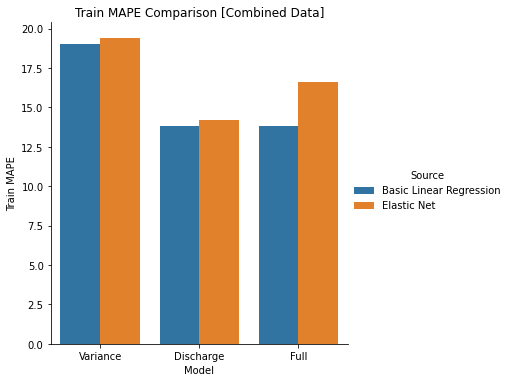

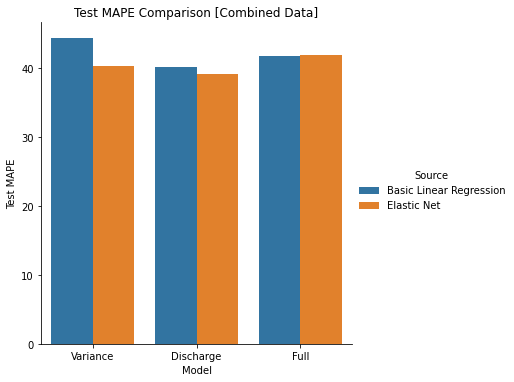

In [122]:
for column in all_data_metrics.columns[3:]:
    sns.catplot(data = all_data_metrics, kind="bar",
               x = "Model", y = column, hue = "Source")
    plt.title(column + " Comparison [Combined Data]")

In [123]:
enet_mapes = []
enet_rmses = []
lr_mapes = []
lr_rmses = []

for data in [old_data_metrics, new_data_metrics, all_data_metrics]:
    for i in range(1, 6, 2):
        enet_mapes.append(data.iloc[i]["Test MAPE"])
        enet_rmses.append(data.iloc[i]["Test RMSE"])

    for i in range(0, 6, 2):
        lr_mapes.append(data.iloc[i]["Test MAPE"])
        lr_rmses.append(data.iloc[i]["Test RMSE"])

all_metrics = pd.DataFrame(data = {
    
    "Model": ["Basic Linear Regression"]*9 + ["Elastic Net"]*9,
    
    "Data Source": ["Old"]*3 + ["New"]*3 + ["Combined"]*3 + ["Old"]*3 + ["New"]*3 + ["Combined"]*3,
    
    "Model Features": ["Variance", "Discharge", "Full",
                       "Variance", "Discharge", "Full",
                       "Variance", "Discharge", "Full",
                       "Variance", "Discharge", "Full",
                       "Variance", "Discharge", "Full",
                       "Variance", "Discharge", "Full"],
    
    "Mean Absolute Percent Error": lr_mapes + enet_mapes,
    
    "RSME": lr_rmses + enet_rmses
})

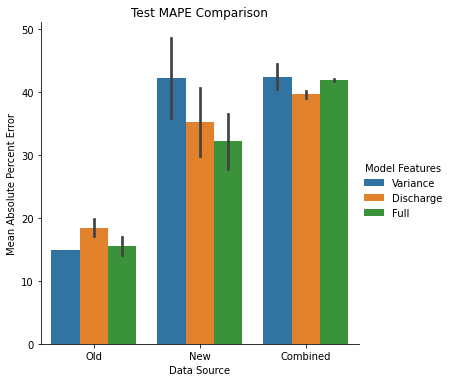

In [124]:
sns.catplot(data = all_metrics, kind="bar",
            x = "Data Source", y = "Mean Absolute Percent Error", hue = "Model Features")
plt.title("Test MAPE Comparison");

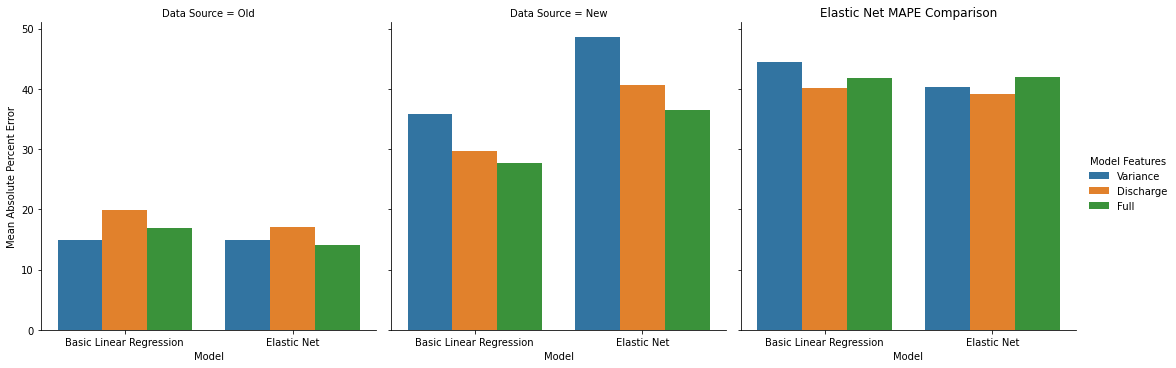

In [125]:
sns.catplot(data = all_metrics, kind="bar",
            x = "Model", y = "Mean Absolute Percent Error", hue = "Model Features", col="Data Source")
plt.title("Elastic Net MAPE Comparison");

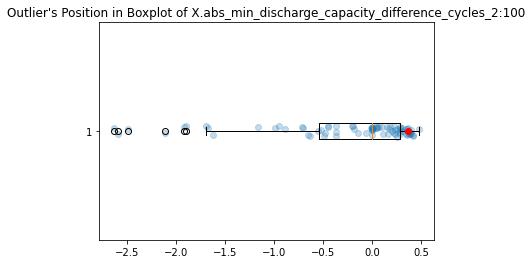

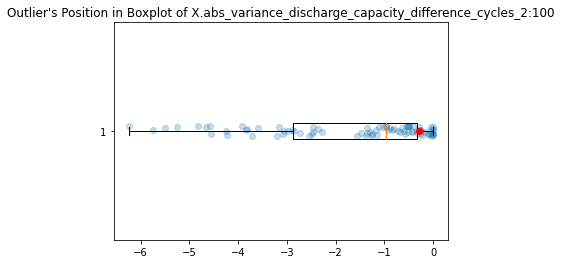

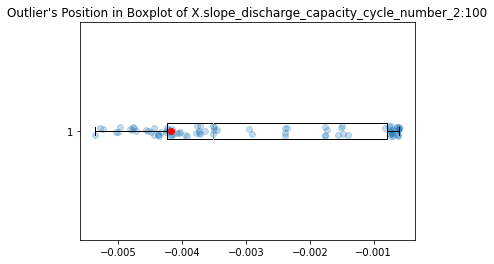

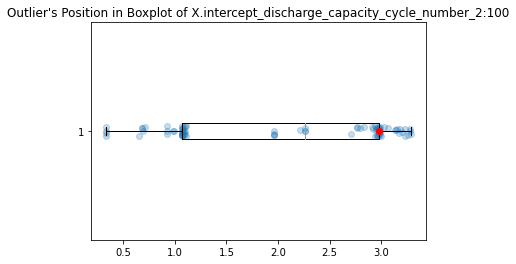

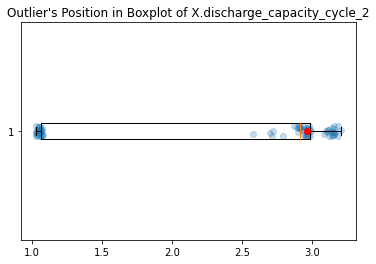

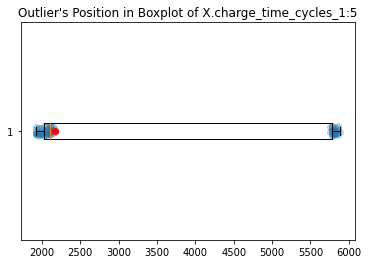

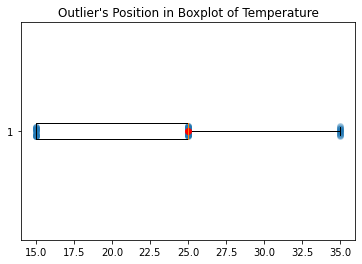

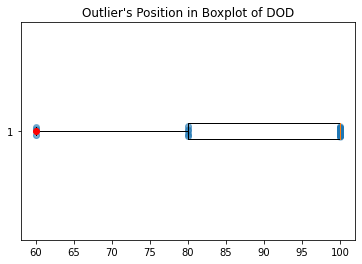

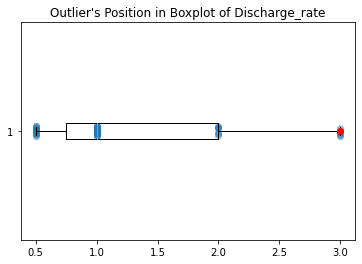

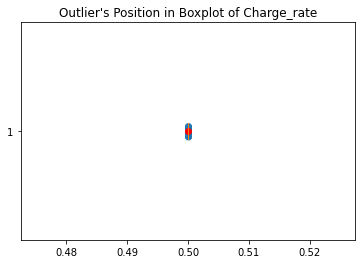

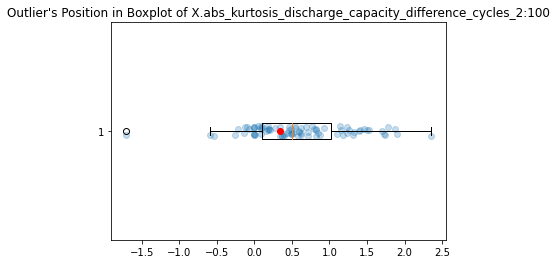

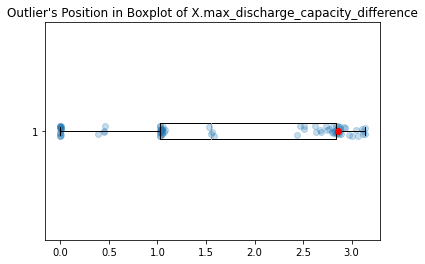

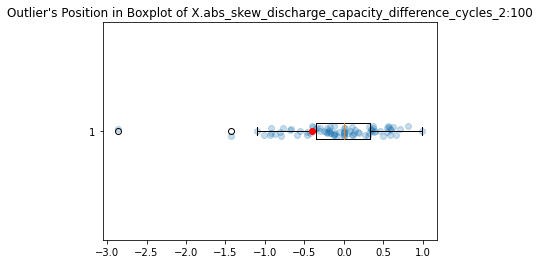

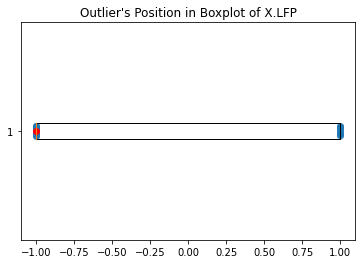

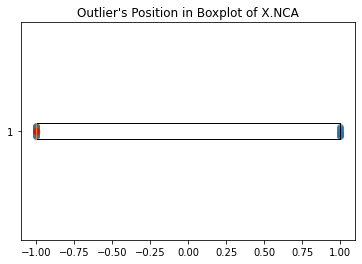

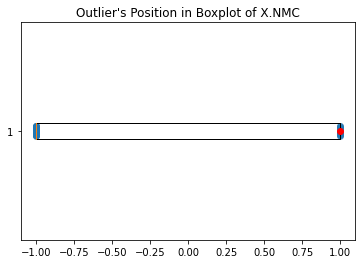

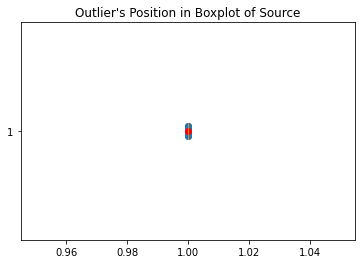

In [126]:
import random

if ct:
    outlier = new_ct_full[new_ct_full["charge_throughput"] > 8000]

for var in all_model_features:
    plt.boxplot(x=new_ct_full[var], vert=False)
    plt.scatter(x=new_ct_full[var], y=[random.uniform(0.95,1.05) for i in range(len(new_ct_full))], alpha=0.25)
    plt.plot(outlier[var].iloc[0], 1, marker="o", color="red")
    plt.ylim(0,2)
    plt.title("Outlier's Position in Boxplot of " + var)
    plt.show()